# Convolutional Neural Network - MNIST

Make Your First GAN With PyTorch, 2020

In [1]:
from rich import print

## import libraries

In [2]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

# Helper Functions

In [3]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

## Load Data

<Figure size 432x288 with 1 Axes>

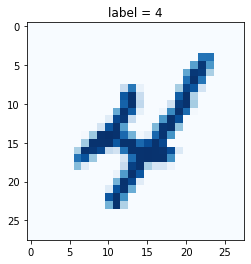

In [4]:
import mnist_data

train_csv = mnist_data.datadir.joinpath('mnist_train.csv')
mnist_dataset = mnist_data.MnistDataset(train_csv)

# check data contains images

mnist_dataset.plot_image(9)

## Neural Network Class

In [5]:
class Classifier(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
        
            # 10 filters to 10 filters
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        
        # print counter every 10000
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwargs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16, 8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot(**plt_kwargs)

## Train Neural Network

In [6]:
%%time 

# create neural network
C = Classifier()

# train network on MNIST data set

epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)

training epoch 1 of 4

counter =  10000

counter =  20000

counter =  30000

counter =  40000

counter =  50000

counter =  60000

training epoch 2 of 4

counter =  70000

counter =  80000

counter =  90000

counter =  100000

counter =  110000

counter =  120000

training epoch 3 of 4

counter =  130000

counter =  140000

counter =  150000

counter =  160000

counter =  170000

counter =  180000

training epoch 4 of 4

counter =  190000

counter =  200000

counter =  210000

counter =  220000

counter =  230000

counter =  240000

CPU times: user 4h 44min 56s, sys: 5h 20min 24s, total: 10h 5min 20s
Wall time: 42min 3s


<Figure size 1152x576 with 1 Axes>

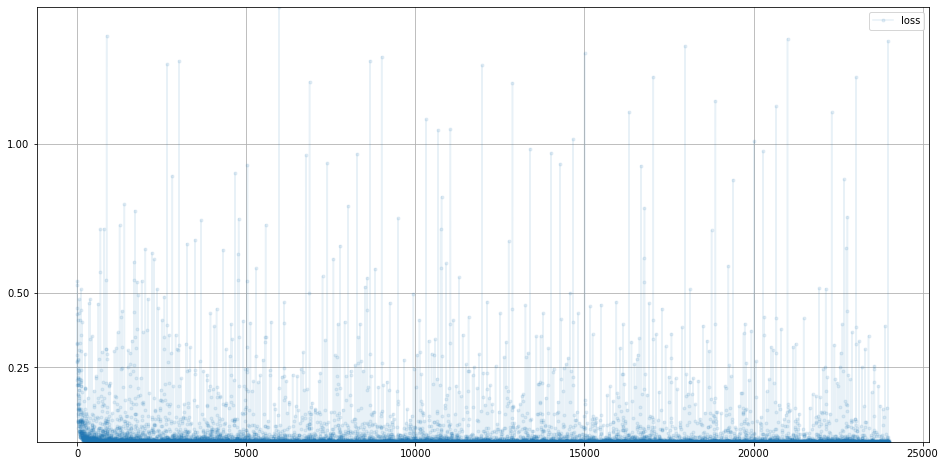

In [7]:
# plot classifier error

C.plot_progress()

## Classification Example

In [8]:
# load MNIST test data

test_csv = mnist_data.datadir.joinpath("mnist_test.csv")
mnist_test_dataset = mnist_data.MnistDataset(test_csv)

<Figure size 432x288 with 1 Axes>

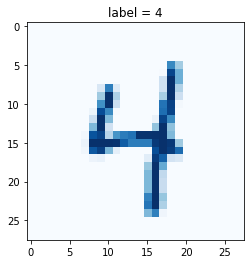

In [9]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

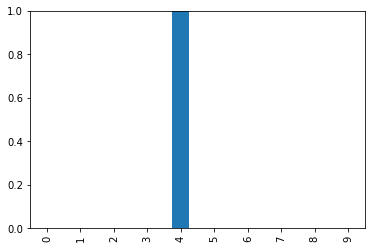

In [10]:
# visualise the answer given by the neural network

image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data.view(1,1,28,28))

# plot output tensor
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

## Classifier Performance

In [11]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().numpy()
    if (answer.argmax() == label):
        score += 1
    items += 1

print(f"{score = }, {items = }, {score/items = }")

score = 9810, items = 10000, score/items = 0.981

## pickle and save the trained CNN

In [12]:
import dill as pickle

In [13]:
with open('cnn_mnist.pkl', 'wb') as f:
    pickle.dump(C, f)